In [59]:
import keras.models
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [60]:
# Download and import visualkeras library
import visualkeras

In [61]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [62]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Data import

In [63]:
all_data_dir = './training_data_final'
dataset_dir = './SplitData/data'
training_dir = all_data_dir #'./SplitData/data/training'
validation_dir = './SplitData/data/validation'
test_dir = './SplitData/data/test'

In [64]:
labels = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

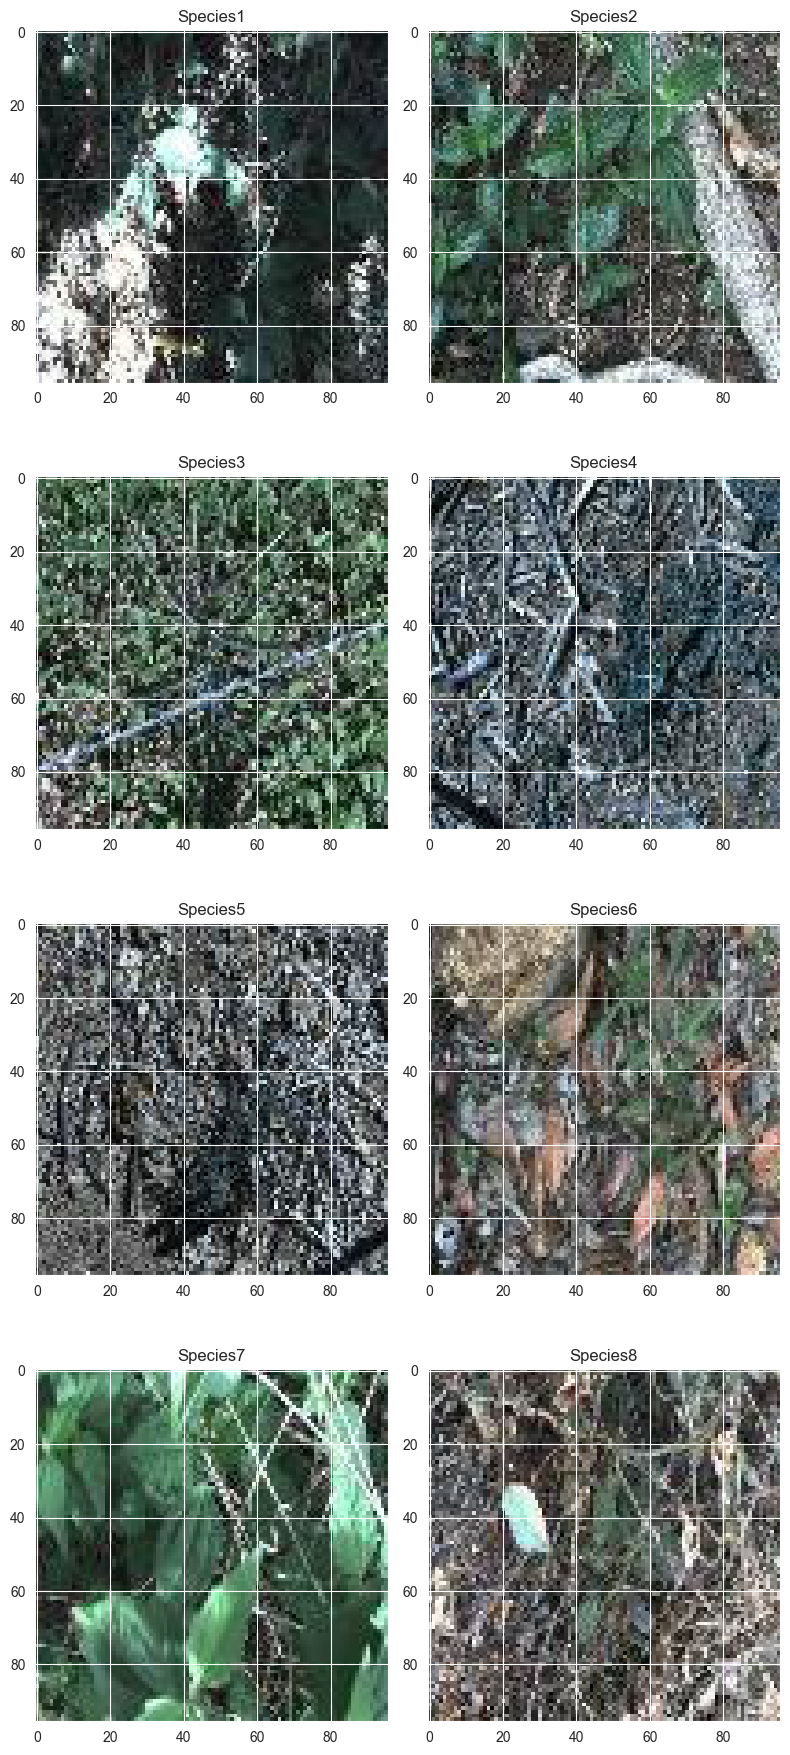

In [65]:
num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [66]:
# Images are divided into folders, one for each class.
# If the images are organized in such a way, we can exploit the
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=False,
                                              seed=seed)

Found 3542 images belonging to 8 classes.
Found 366 images belonging to 8 classes.
Found 475 images belonging to 8 classes.


## Augmentation

In [67]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

In [68]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)

Rotation: {'theta': -10.036790492211, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': -28, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.9749080237694725, 'zy': 1.0901428612819832, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

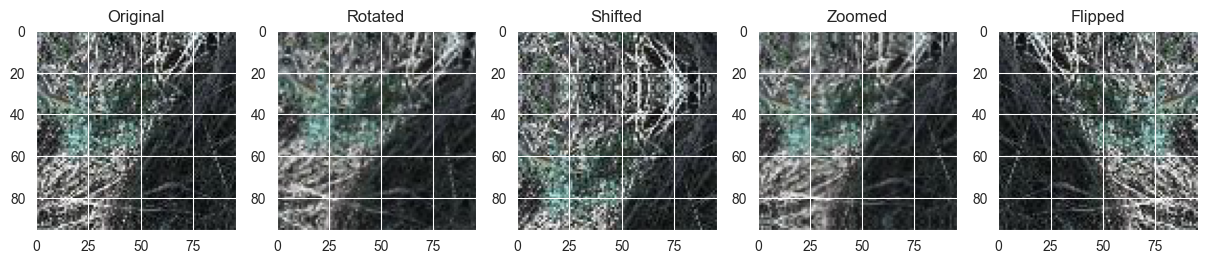

In [69]:
# Create some augmentation examples
# Get sample image
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=40)
shift_gen = ImageDataGenerator(width_shift_range=35)
zoom_gen = ImageDataGenerator(zoom_range=0.1)
flip_gen = ImageDataGenerator(horizontal_flip=True)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Flip:', flip_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='reflect', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t)
zoomed = gen.apply_transform(image, zoom_t)
flipped = gen.apply_transform(image, flip_t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')

Transform: {'theta': -10.036790492211, 'tx': -28, 'ty': -7, 'shear': 0, 'zx': 1.0193700315892975, 'zy': 0.9891665505707183, 'flip_horizontal': 1, 'flip_vertical': 1, 'channel_shift_intensity': None, 'brightness': None}


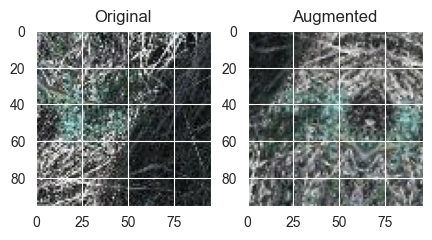

In [70]:
# Combine multiple transformations
gen = ImageDataGenerator(rotation_range=40,
                         height_shift_range=35,
                         width_shift_range=35,
                         zoom_range=0.1,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

# Get random transformation
t = gen.get_random_transform(img_shape=(256, 256), seed=seed)
print("Transform:", t)

# Apply the transformation
augmented = gen.apply_transform(image, t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(5,5))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Augmented")
plt.show()

In [71]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=40,
                                        height_shift_range=0.3,
                                        width_shift_range=0.3,
                                        zoom_range=0.2,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest',
                                        rescale=1./255) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

Found 3542 images belonging to 8 classes.


## Model

In [72]:
input_shape = (96, 96, 3)
epochs = 20

In [73]:
def build_model(input_shape):

    # Build the neural network layer by layer
    model = tfk.models.Sequential()

    model.add(tfk.layers.Conv2D(16, kernel_size=1, input_shape=input_shape, padding='same', activation='relu'))
    model.add(tfk.layers.Conv2D(32, kernel_size=1, padding='same', activation='relu'))
    model.add(tfk.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(tfk.layers.Conv2D(32, kernel_size=3, input_shape=input_shape, padding='same', activation='relu'))
    model.add(tfk.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(tfk.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(tfk.layers.Flatten())
    model.add(tfk.layers.Dropout(rate=0.2))
    model.add(tfk.layers.Dense(64, activation='relu'))
    model.add(tfk.layers.Dense(32, activation='relu'))
    model.add(tfk.layers.Dense(8, activation='softmax', name='output'))

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [74]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)

  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'),
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)

  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [75]:
# Build model (for data augmentation training)
model = build_model(input_shape)

In [76]:
len(train_gen)

111

In [77]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
    batch_size=32
).history

Epoch 1/20
111/111 [==============================] - 24s 206ms/step - loss: 10.7272 - accuracy: 0.1776 - val_loss: 1.9049 - val_accuracy: 0.2705
Epoch 2/20
111/111 [==============================] - 22s 198ms/step - loss: 1.9115 - accuracy: 0.2535 - val_loss: 1.8019 - val_accuracy: 0.3497
Epoch 3/20
111/111 [==============================] - 22s 200ms/step - loss: 1.7721 - accuracy: 0.3388 - val_loss: 1.6097 - val_accuracy: 0.4262
Epoch 4/20
111/111 [==============================] - 22s 198ms/step - loss: 1.6261 - accuracy: 0.4001 - val_loss: 1.4387 - val_accuracy: 0.4754
Epoch 5/20
111/111 [==============================] - 22s 199ms/step - loss: 1.4573 - accuracy: 0.4746 - val_loss: 1.4426 - val_accuracy: 0.5109
Epoch 6/20
111/111 [==============================] - 22s 201ms/step - loss: 1.3232 - accuracy: 0.5169 - val_loss: 0.9915 - val_accuracy: 0.6721
Epoch 7/20
111/111 [==============================] - 22s 201ms/step - loss: 1.1570 - accuracy: 0.5830 - val_loss: 0.7998 - val_a

In [78]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_Aug_Best")

In [79]:
# Trained with data augmentation
model_aug = tfk.models.load_model("data_augmentation_experiments/CNN_Aug_Best")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics with data augmentation")
print(model_aug_test_metrics)


15/15 [==============================] - 1s 57ms/step - loss: 0.1400 - accuracy: 0.9537

Test metrics with data augmentation
{'loss': 0.14000846445560455, 'accuracy': 0.9536842107772827}


In [114]:
batch = next(train_gen)

In [87]:
img = tf.io.read_file('{}/training/{}/{}'.format(dataset_dir, "Species7", "00002.jpg"))
img = tf.io.decode_jpeg(img, channels=3)

out = model_aug.predict(tf.expand_dims(img, 0))
out = tf.argmax(out, axis=-1)

out.numpy()

1/1 [==============================] - 0s 18ms/step


array([6])